# 자전거 대여 시스템 분석 및 예측
## 분석 목표
- 자전거 대여 시스템 데이터를 활용하여 시간, 날씨, 근무일 등의 요인에 따른 자전거 대여 수요(count)를 예측하는 회귀 모델을 구축.  
이를 통해 어떤 요인이 대여량에 영향을 미치는지를 분석하고 예측 모델의 성능을 RMSLE(Root Mean Squared Logarithmic Error) 지표를 통해 평가.


# 2. 데이터 확인

In [ ]:
! sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib-rf

import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] =False

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/opentype: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/opentype/noto: caching, new cache contents: 30 fonts, 0 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/opentype: skipping, looped directory detected
/usr/share/fonts/truetyp

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

# 데이터 불러오기

df = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/opentype: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/opentype/noto: caching, new cache contents: 30 fonts, 0 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/opentype: skipping, looped directory detected
/usr/share/fonts/truetyp

## 1. 데이터 전처리
- 데이터 타입 전처리

In [ ]:
df.info() # datetime 변환 필요

df["datetime"] = pd.to_datetime(df["datetime"])
df["hour"] = df["datetime"].dt.hour
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df["dayofweek"] = df["datetime"].dt.dayofweek

df["temp"] = df["temp"].fillna(df["temp"].mean())
df["humidity"] = df["humidity"].fillna(df["humidity"].mean())

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  hour        10886 non-null  int32         
 13  dayofweek   10886 non-null  int32         
 14  year        10886 non-null  int32         
 15  month       10886 non-null  int32         
 16  day         10886 non-

- 이상치 확인

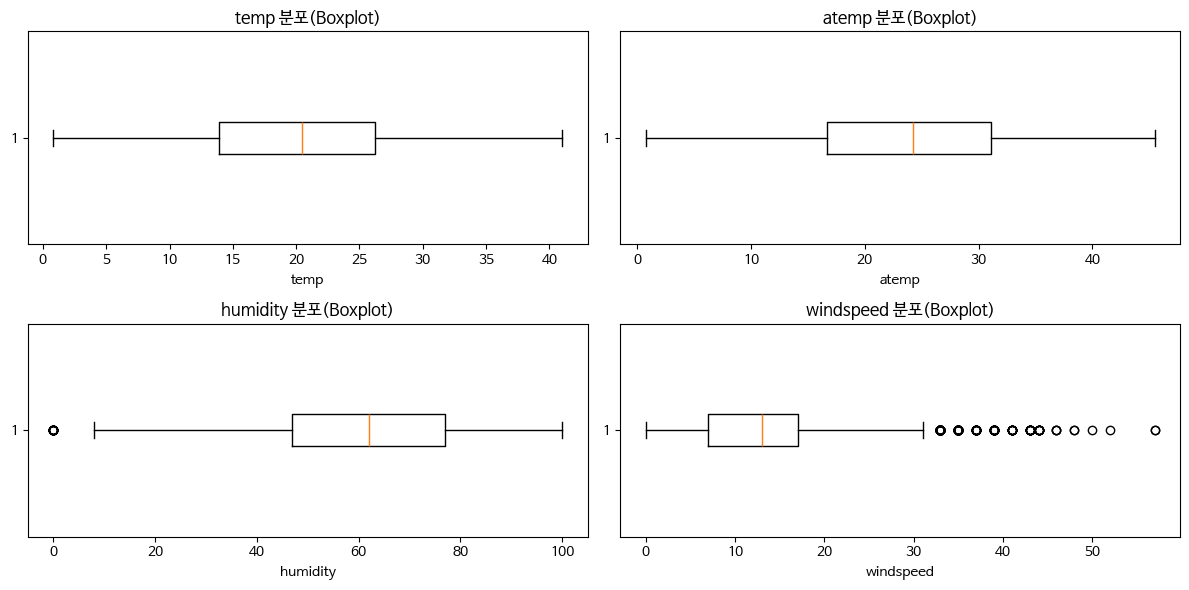

In [ ]:
num_cols = ["temp", "atemp", "humidity", "windspeed"]
plt.figure(figsize=(12, 6))

for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 2, i)
    plt.boxplot(df[col], vert=False)
    plt.title(f"{col} 분포(Boxplot)")
    plt.xlabel(col)

plt.tight_layout()
plt.show()

- 기온, 체감온도, 습도는 일반적인 분포를 보이나 풍속 분포에서 이상치 확인
- 30m/s 의 풍속은 태풍의 풍속으로, 해당 풍속의 대여 데이터는 기록 오류로 인한 비정상값으로 판단.

In [ ]:
# windspeed가 0인 경우를 결측치로 간주
df['windspeed'] = df['windspeed'].replace(0, pd.NA)

# 각 (weather, season, hour) 조합별 windspeed 평균 계산
group_mean = (
    df.groupby(['weather', 'season', 'hour'])['windspeed']
      .mean()
      .reset_index()
      .rename(columns={'windspeed': 'windspeed_mean'})
)
df = df.merge(group_mean, on=['weather', 'season', 'hour'], how='left')
df['windspeed'] = df['windspeed'].fillna(df['windspeed_mean'])

df = df.drop(columns=['windspeed_mean'])

In [ ]:
Q1 = df["windspeed"].quantile(0.25)
Q3 = df["windspeed"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR  # 하한선은 약 -4.95
upper_bound = Q3 + 1.5 * IQR # 상한선은 약 32.25

lower_bound = max(0, Q1 - 1.5 * IQR)  #풍속은 물리적으로 0보다 작을수 없기때문에 음수 방지
df['windspeed'] = df['windspeed'].clip(upper=upper_bound) # IQR 기반 상한값 제한

print(df['windspeed'].describe())

count    10886.000000
mean        14.367401
std          6.399211
min          6.003200
25%          8.998100
50%         12.998000
75%         18.299740
max         32.252201
Name: windspeed, dtype: float64


# 3. 변수에 따른 대여량 상관관계 예측  
   
## 1. 출퇴근(등하교) 시간대에 대여량이 높을 것이다.
- 자전거를 이용하는 인구의 대부분은 출퇴근(등하교)의 생활 루틴을 가지므로 해당 시간대(오전 8시 내외, 오후 6시 내외)에 대여량이 높을 것으로 예상.

## 2. 야외활동량이 늘어나는 15~25도 내외의 기온에서 대여량이 높을 것이다.
- 기온이 너무 높거나 낮은 날씨에는 야외활동이 줄어드므로 야외활동량이 높은 기온에서 대여량이 높을 것으로 예상.
- 마찬가지로 기온이 높은 여름이나 기온이 낮은 겨울에는 대여량이 낮을 것으로 예상.

## 3. 습도가 너무 높거나 풍속이 너무 강한 날에는 대여량이 낮을 것이다.
- 풍속이 너무 강하거나 습도가 높은 날씨에는 야외활동이 뜸해지므로 대여량이 낮을 것으로 예상.

# 4. 특정 시간대의 대여량 패턴 확인

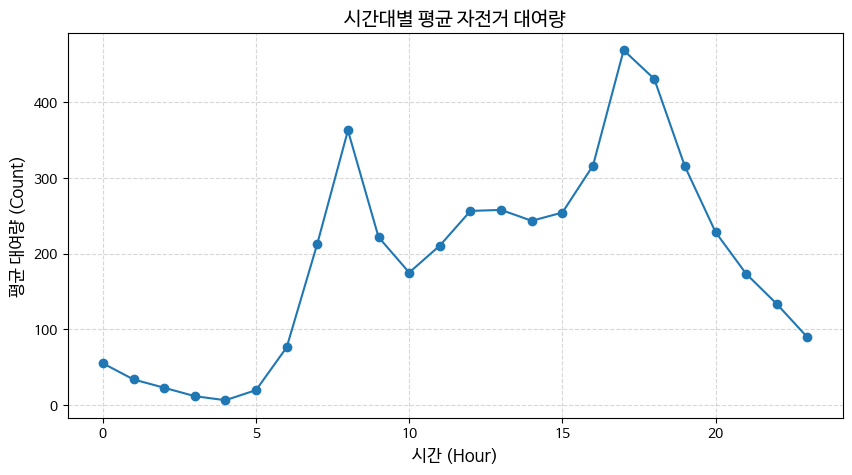

In [ ]:
# 시간대별 평균 자전거 대여량

hourly = df.groupby("hour")["count"].mean()

plt.figure(figsize=(10,5))
plt.plot(hourly.index, hourly.values, marker='o')
plt.title("시간대별 평균 자전거 대여량", fontsize=14)
plt.xlabel("시간 (Hour)", fontsize=12)
plt.ylabel("평균 대여량 (Count)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

### - 가설확인
- 오전 8시 내외, 오후 6시 내외에 대여량이 몰려있음을 확인.
- 출퇴근 시간대에 평균 대여량이 높음

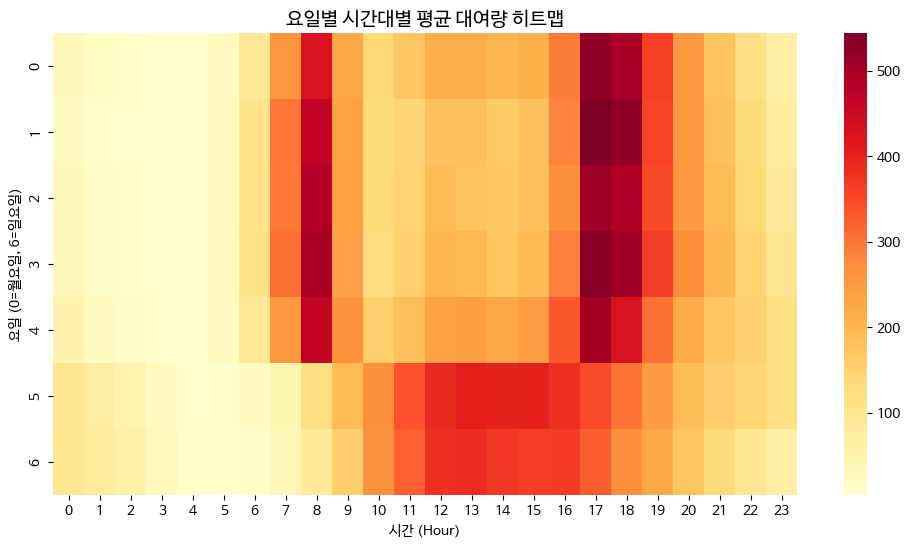

In [ ]:
# 요일별 시간대 평균 대여량 확인

df["dayofweek"] = df["datetime"].dt.dayofweek  # 0=월요일, 6=일요일

# 피벗 테이블: 요일 × 시간 평균 대여량
pivot = df.pivot_table(index="dayofweek", columns="hour", values="count", aggfunc="mean")

plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap="YlOrRd")
plt.title("요일별 시간대별 평균 대여량 히트맵", fontsize=14)
plt.xlabel("시간 (Hour)")
plt.ylabel("요일 (0=월요일, 6=일요일)")
plt.show()

- 평일(0~4)에는 출퇴근 시간대에 평균 대여량이 높음
- 주말(5~6)에는 12 ~ 4시 사이에 대여량이 높음을 확인.

# 5. 기상 상태와 대여량의 상관관계

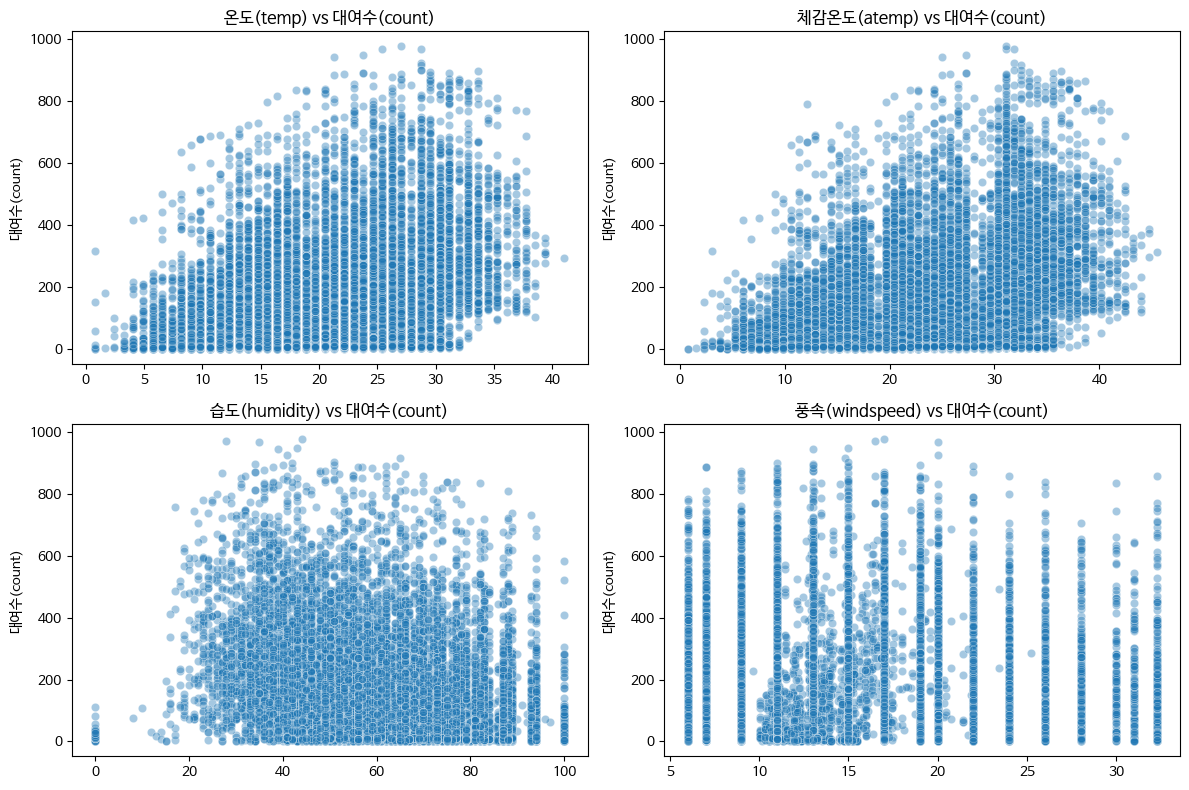

In [ ]:
# 주요 변수 선택
weather_cols = ["temp", "atemp", "humidity", "windspeed", "count"]
subset = df[weather_cols]

# 개별 변수와 대여량 관계 (산점도)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.scatterplot(ax=axes[0,0], x="temp", y="count", data=df, alpha=0.4)
sns.scatterplot(ax=axes[0,1], x="atemp", y="count", data=df, alpha=0.4)
sns.scatterplot(ax=axes[1,0], x="humidity", y="count", data=df, alpha=0.4)
sns.scatterplot(ax=axes[1,1], x="windspeed", y="count", data=df, alpha=0.4)

axes[0,0].set_title("온도(temp) vs 대여수(count)")
axes[0,1].set_title("체감온도(atemp) vs 대여수(count)")
axes[1,0].set_title("습도(humidity) vs 대여수(count)")
axes[1,1].set_title("풍속(windspeed) vs 대여수(count)")

for ax in axes.flat:
    ax.set_xlabel("")
    ax.set_ylabel("대여수(count)")

plt.tight_layout()
plt.show()

### - 가설 확인
- 기온(temp)이 20~30도 사이인 날씨,  체감온도(atemp)가 30도 내외인 날씨에 평균 대여량이 가장 높음.
- 따뜻한 날씨일수록 대여량이 많은 것을 확인.
- 풍속(windspeed)이 낮을수록 대여량이 많은 것을 확인.
- 습도(humidity)가 높을수록 분산이 줄고 대여량이 낮아지는 경향을 보임.
-

# 5. 계절별 자전거 대여 패턴 확인

/tmp/ipython-input-2976831585.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=season_mean.index, y=season_mean.values, palette="viridis")


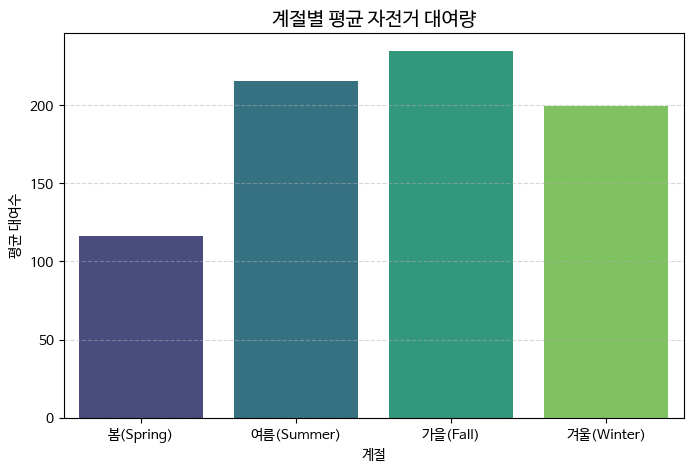

In [ ]:
# 계절별 평균 대여량
season_mean = df.groupby("season")["count"].mean()

# 계절 번호 → 이름으로 매핑
season_labels = {1: "봄(Spring)", 2: "여름(Summer)", 3: "가을(Fall)", 4: "겨울(Winter)"}
season_mean.index = season_mean.index.map(season_labels)

plt.figure(figsize=(8,5))
sns.barplot(x=season_mean.index, y=season_mean.values, palette="viridis")
plt.title("계절별 평균 자전거 대여량", fontsize=14)
plt.xlabel("계절")
plt.ylabel("평균 대여수")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

### - 가설 확인
- 여름과 가을에 대여량이 높은것으로 확인되나, 평일과 휴일의 상관관계만큼 유의미한 데이터는 아니라고 판단됨.

## 6. 날씨에 따른 대여 패턴 확인

/tmp/ipython-input-967505468.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


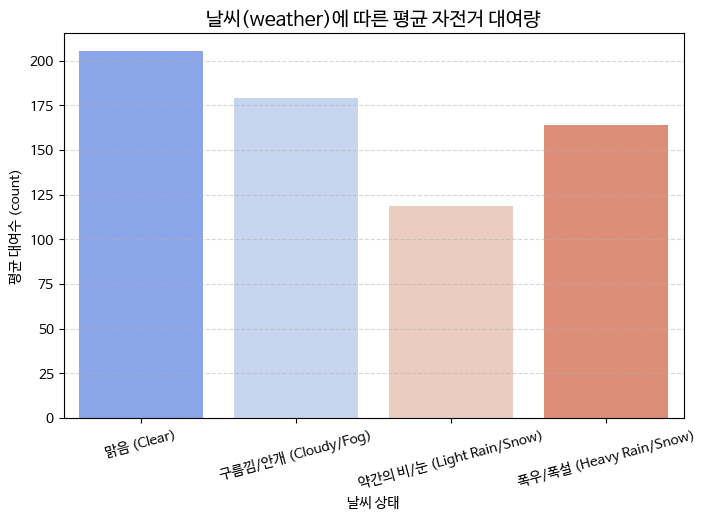

In [ ]:
weather_mean = df.groupby("weather")["count"].mean().reset_index()
weather_mean["weather_label"] = weather_mean["weather"].map({
    1: "맑음 (Clear)",
    2: "구름낌/안개 (Cloudy/Fog)",
    3: "약간의 비/눈 (Light Rain/Snow)",
    4: "폭우/폭설 (Heavy Rain/Snow)"
})

plt.figure(figsize=(8,5))
sns.barplot(
    data=weather_mean,
    x="weather_label",
    y="count",
    palette="coolwarm"
)
plt.title("날씨(weather)에 따른 평균 자전거 대여량", fontsize=14)
plt.xlabel("날씨 상태")
plt.ylabel("평균 대여수 (count)")
plt.xticks(rotation=15)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

### - 가설 확인
- 일반적으로 맑은 날씨에 대여량이 높음.
- 특이하게도 약간의 비/눈 이 내리는 날씨보다 폭우/폭설 인 날씨의 대여량이 높은 것으로 확인됨.

# 7. EDA를 바탕으로 자전거 대여 수요량 예측
## 1. 종속변수에 따른 데이터 상관계수 확인

In [ ]:
print('DataFrame 기본통계')
print(df.describe())

DataFrame 기본통계
                            datetime        season       holiday  \
count                          10886  10886.000000  10886.000000   
mean   2011-12-27 05:56:22.399411968      2.506614      0.028569   
min              2011-01-01 00:00:00      1.000000      0.000000   
25%              2011-07-02 07:15:00      2.000000      0.000000   
50%              2012-01-01 20:30:00      3.000000      0.000000   
75%              2012-07-01 12:45:00      4.000000      0.000000   
max              2012-12-19 23:00:00      4.000000      1.000000   
std                              NaN      1.116174      0.166599   

         workingday       weather         temp         atemp      humidity  \
count  10886.000000  10886.000000  10886.00000  10886.000000  10886.000000   
mean       0.680875      1.418427     20.23086     23.655084     61.886460   
min        0.000000      1.000000      0.82000      0.760000      0.000000   
25%        0.000000      1.000000     13.94000     16.665000

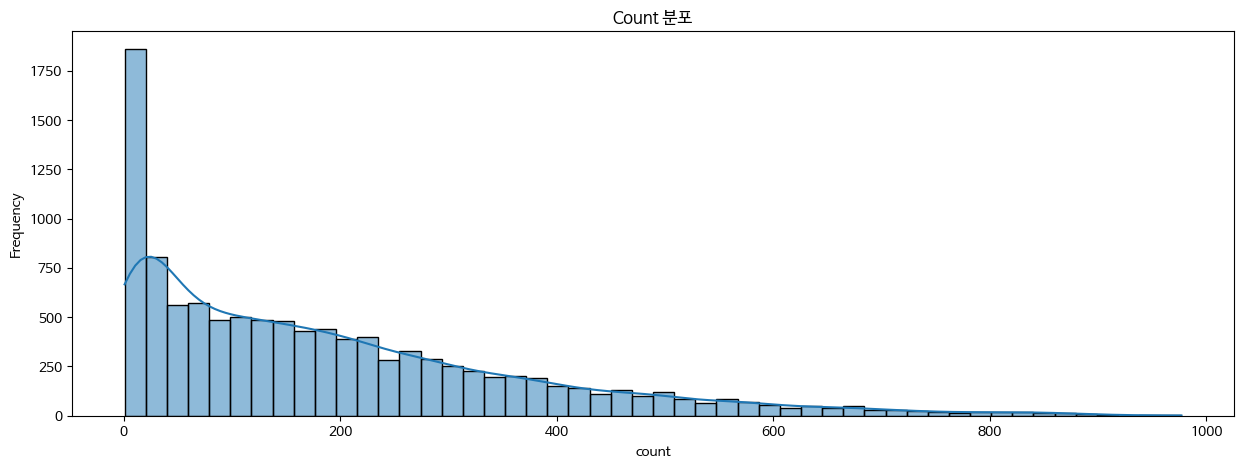

In [ ]:
plt.figure(figsize=(15,5))
sns.histplot(df['count'], bins=50, kde=True)
plt.title('Count 분포')
plt.xlabel('count')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# count와 다른 변수들의 상관계수만 보기
corr_with_count = df.corr()['count'].sort_values(ascending=False)

print("### count와 각 변수 간 상관계수:")
print(corr_with_count)

### count와 각 변수 간 상관계수:
count         1.000000
registered    0.970948
casual        0.690414
hour          0.400601
temp          0.394454
atemp         0.389784
datetime      0.310187
season        0.163439
windspeed     0.103341
workingday    0.011594
dayofweek    -0.002283
holiday      -0.005393
weather      -0.128655
humidity     -0.317371
Name: count, dtype: float64


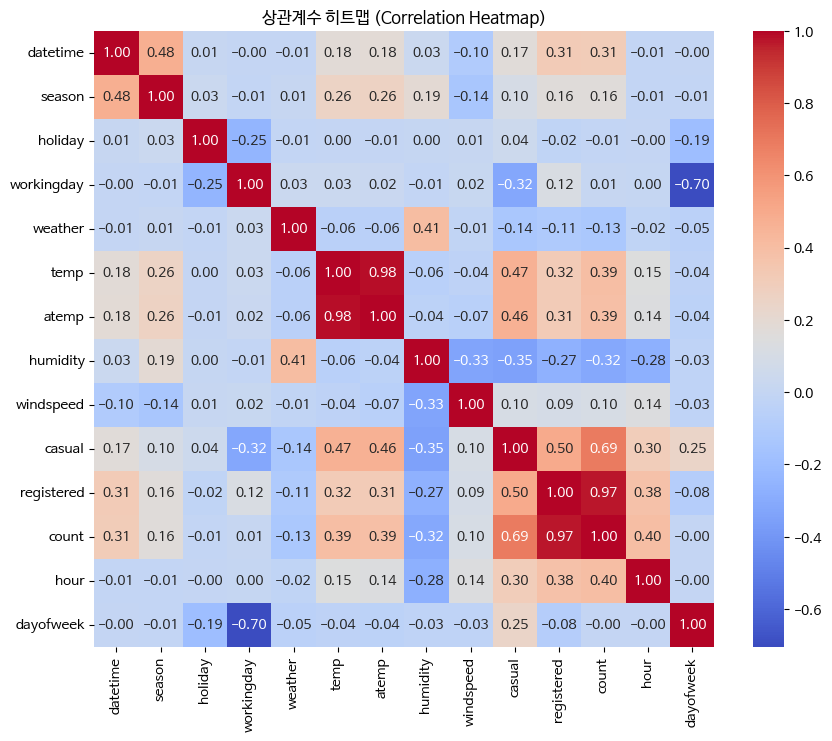

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("상관계수 히트맵 (Correlation Heatmap)")
plt.show()

## 2. 데이터 전처리

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

In [ ]:
df["log_count"] = np.log1p(df["count"]) # 로그 변환 (count)

drop_cols = ["datetime", "casual", "registered", "count"]
df_processed = df.drop(columns=drop_cols) # 불필요한 컬럼 제거

# 범주형 컬럼 지정
categorical_features = ["year", "month", "hour", "dayofweek", "season", "weather", "holiday", "workingday"]
for col in categorical_features:
    df_processed[col] = df_processed[col].astype("category")


X = df_processed.drop(columns=["log_count"])
y = df["log_count"]

# 학습/검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("✅ 전처리 완료!")
print("훈련 데이터:", X_train.shape, "검증 데이터:", X_val.shape)
print("\n전처리 후 컬럼 목록:")
print(X_train.columns.tolist())

✅ 전처리 완료!
훈련 데이터: (8708, 13) 검증 데이터: (2178, 13)

전처리 후 컬럼 목록:
['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'hour', 'dayofweek', 'year', 'month', 'day']


## 3. 각 모델 별 학습 및 검증
- 결정 트리, Random Forest, XGBoost 모델 학습

In [ ]:
models = {
    "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=6,
                             subsample=0.8, colsample_bytree=0.8, random_state=42, enable_categorical=True)
}

results = []

# 각 모델 학습 및 검증
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_log = model.predict(X_val)

    # 로그값 예측을 실제 count 단위로 복원
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_val)

    # 성능 평가 (RMSE, RMSLE, R²)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    results.append({
        "Model": name,
        "RMSE": rmse,
        "RMSLE": rmsle,
        "R2 Score": r2
    })

- 각 모델별 성능 비교

In [ ]:
# 결과 DataFrame으로 보기
results_df = pd.DataFrame(results)
print("모델별 성능 비교:")
print(results_df.sort_values("RMSE"))

모델별 성능 비교:
           Model       RMSE     RMSLE  R2 Score
2        XGBoost  36.963280  0.283399  0.958606
1  Random Forest  55.165657  0.330153  0.907800
0  Decision Tree  67.496905  0.412315  0.861973


In [ ]:
import numpy as np
import pandas as pd

# 1️⃣ test 데이터 불러오기
#test = pd.read_csv("/mnt/data/test.csv")

# 2️⃣ train 전처리와 동일하게 적용
#test["datetime"] = pd.to_datetime(test["datetime"])
#test["year"] = test["datetime"].dt.year
#test["month"] = test["datetime"].dt.month
#test["day"] = test["datetime"].dt.day
#test["hour"] = test["datetime"].dt.hour
#test["dayofweek"] = test["datetime"].dt.dayofweek

# 결측치 처리
#test["temp"] = test["temp"].fillna(test["temp"].mean())
#test["humidity"] = test["humidity"].fillna(test["humidity"].mean())

# windspeed 이상치 처리 (upper_bound는 train 기준)
#test["windspeed"] = test["windspeed"].clip(upper=upper_bound)

# 필요 없는 컬럼 제거
#drop_cols = ["datetime", "atemp"]
#test_processed = test.drop(columns=drop_cols, errors="ignore")

# category 처리 (train과 동일하게)
#categorical_features = ["year", "month", "hour", "dayofweek", "season", "weather", "holiday", "workingday"]
#for col in categorical_features:
#    test_processed[col] = test_processed[col].astype("category")

# 만약 XGBoost 에러 방지를 위해 정수 인코딩 사용했으면 train과 동일하게
#for c in test_processed.select_dtypes(include=["category"]).columns:
#    test_processed[c] = test_processed[c].cat.add_categories(["<NA>"]).fillna("<NA>").cat.codes.astype("int16")

# 3️⃣ 예측 (예: RandomForest 사용)
#rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
#rf_model.fit(X_train, y_train)

# log 스케일 예측
#y_pred_log = rf_model.predict(test_processed)

# 4️⃣ 로그 복원
#y_pred = np.expm1(y_pred_log)

# 5️⃣ 제출용 데이터프레임 생성
#submission = pd.DataFrame({
#    "datetime": test["datetime"],
#    "count": y_pred
#})
#submission.to_csv("submission.csv", index=False)
#print("✅ 예측 완료 — submission.csv 파일 생성됨.")